# Saving Branch

# Importing Libraries

In [24]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Check for GPU availability
if tf.config.list_physical_devices("GPU"):
    print("GPU is available.")
    physical_devices = tf.config.list_physical_devices("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
else:
    print("GPU is not available. Switching to CPU.")

GPU is not available. Switching to CPU.


# Creating fake data to replicate

In [26]:
# Define the desired number of samples for each class
class_samples = [2000, 3000, 2500, 1500]  # Adjust these numbers as needed

# Calculate weights based on the desired number of samples
class_weights = [num_samples / sum(class_samples) for num_samples in class_samples]


# Generate a synthetic dataset with different numbers of samples for each class
X, y = make_classification(
    n_samples=sum(class_samples),
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_classes=4,
    weights=class_weights,
    random_state=42,
)

# Create a Pandas DataFrame with the generated data
columns = ["Feature_1", "Feature_2", "Feature_3", "Feature_4"]
synthetic_df = pd.DataFrame(data=X, columns=columns)

for column in synthetic_df:
    std = np.std(synthetic_df[column])
    mean = np.mean(synthetic_df[column])
    synthetic_df[column] = synthetic_df[column]-mean
    synthetic_df[column] = synthetic_df[column]/std


synthetic_df["target"] = y

# Display the first few rows of the synthetic dataset
synthetic_array =synthetic_df.values

# Defining the sampling layer that is also the call

In [27]:
class Sampling(keras.layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Encoder

In [28]:
latent_dim = 10
encoder_inputs = Input(shape=(5), name="input_layer")

n_x = 50
x = Dense(n_x, activation="relu", name="h1")(encoder_inputs)

# Split x into two halves
half_size = n_x // 2
x3_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x)
x3_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x)

z_mean = Dense(latent_dim, name="z_mean")(x3_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x3_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder

In [29]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
n_x = 30

x = Dense(n_x, activation="relu", name="h4")(latent_inputs)

cont_decoder_outputs = Dense(4, activation="linear", name="cont_decoder_output")(x)
class_decoder_output = Dense(4, activation="softmax", name="classification_output")(x)

decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 h4 (Dense)                     (None, 30)           330         ['input_2[0][0]']                
                                                                                                  
 cont_decoder_output (Dense)    (None, 4)            124         ['h4[0][0]']                     
                                                                                                  
 classification_output (Dense)  (None, 4)            124         ['h4[0][0]']                     
                                                                                            

# Custom VAE

In [30]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]

    def call(self, inputs):
        # Define the forward pass
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_cont, reconstruction_class = self.decoder(z)

            data_cont = data[
                :, :4
            ]  # Assuming the first 4 columns are for continuous variables
            data_class = data[:, 4:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.sparse_categorical_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Combine losses
            total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + kl_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {
            "loss": self.total_loss_tracker.result(),
        }

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update(
            {
                "encoder": self.encoder,
                "decoder": self.decoder,
            }
        )
        return config

# Compile and Train

In [31]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [32]:
vae.fit(
    synthetic_array,
    epochs=1,
    batch_size=16,
)

563/563 [==============================] - 1s 1ms/step - loss: 2.3165


In [33]:
vae.save_weights("herre")

In [34]:
vae1 = VAE(encoder, decoder)
vae1.compile(optimizer=keras.optimizers.Adam())

In [35]:
vae1.load_weights("herre")

In [47]:
vae1.weights == vae.weights

True

In [36]:
latent_vectors = np.random.normal(size=(9000, latent_dim))

# Use the decoder to generate data
generated_data_cont, generated_data_class = vae.decoder.predict(latent_vectors)
generated_data_class_transformed = np.argmax(generated_data_class, axis=1)

282/282 [==============================] - 0s 884us/step


In [37]:
# tf.saved_model.save(vae, "my_model_tf")
# loaded_model = tf.saved_model.load("my_model_tf")

# Generate data and visualy inspect

In [38]:
latent_vectors = np.random.normal(size=(9000, latent_dim))

# Use the decoder to generate data
generated_data_cont1, generated_data_class1 = vae1.decoder.predict(latent_vectors)
generated_data_class_transformed1 = np.argmax(generated_data_class, axis=1)

282/282 [==============================] - 0s 1ms/step


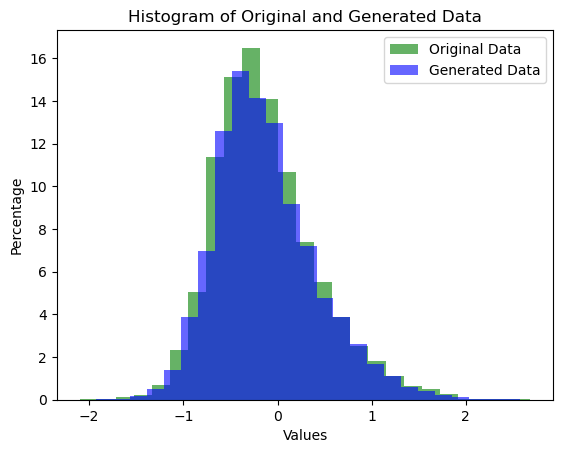

In [40]:
# Plot histogram for original data
first_column_original = generated_data_cont1[:, 2]
total_points_original = len(first_column_original)
percentage_original = (first_column_original / total_points_original) * 100

plt.hist(
    first_column_original,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(first_column_original) / total_points_original * 100,
    label="Original Data",
)

# Plot histogram for generated data
first_column_generated = generated_data_cont[:, 2]
total_points_generated = len(first_column_generated)
percentage_generated = (first_column_generated / total_points_generated) * 100

plt.hist(
    first_column_generated,
    bins=25,
    color="b",
    alpha=0.6,
    weights=np.ones_like(first_column_generated) / total_points_generated * 100,
    label="Generated Data",
)

plt.title("Histogram of Original and Generated Data")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.legend()
plt.show()

In [1]:
# fuck you